In [1]:
# Most Basic
import sys
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import math
import scipy.stats as ss
import copy
import warnings
import datetime as dt
from os import path
from datetime import datetime
from scipy.stats import norm
from DataMaker_New import dataCleaner_new

warnings.simplefilter('ignore')

In [2]:
# Define transition Dynamics
# Positional requirement, no real effect, will be replaced by ESN and BS defined further down
def fx(x, dt):
    return x*dt
def hx(x):
    return x

def sigmoid(x):
    return np.divide(1, 1+np.exp(-x))


def ESNf(theta_now, dt, **fx_args):
    """
    :params theta_now theta_t
    
    **fx_args
    :params G reservoir transition matrix
    :params G_in input translation matrix
    :params b reservoir bias vector
    :params u_quad_now u_t^2
    """
    G = fx_args["G"]
    G_in = fx_args["G_in"]
    b = fx_args["b"]
    u_quad_now = fx_args["u_quad_now"]
    theta_next = sigmoid(np.matmul(G, theta_now) + np.matmul(G_in, u_quad_now) + b)
    return theta_next
    

def BSf(theta_t, **hx_args):
    """
    :params theta_t current state vector
    
    **hx_args
    :params p_t current asset price
    :params r_t current asset price
    :params K_t strike price, 1d vector
    :params T_t maturity time, 1d vector
    """
    p_t = hx_args["p_t"]
    r_t = hx_args["r_t"]
    K_t = hx_args["K_t"]
    T_t = hx_args["T_t"]
    
    volatility_std = np.average(theta_t)
    volatility_var = np.power(volatility_std, 2)
    
    dividor = np.sqrt(volatility_var * T_t)
    d_pls = (np.log(p_t/K_t) + np.multiply(r_t+volatility_var/2, T_t)) / dividor
    d_mns = (np.log(p_t/K_t) + np.multiply(r_t-volatility_var/2, T_t)) / dividor
    y_t = np.multiply(p_t, norm.cdf(d_pls)) - np.multiply(np.multiply(K_t, np.exp(-r_t*T_t)), norm.cdf(d_mns))
    return y_t

def BSfNT(theta_t, p_t, r_t, K_t, T_t, target):
    """
    :params theta_t current state vector
    
    **hx_args
    :params p_t current asset price
    :params r_t current asset price
    :params K_t strike price, 1d vector
    :params T_t maturity time, 1d vector
    """
    
    volatility_std = np.average(theta_t)
    volatility_var = np.power(volatility_std, 2)
    
    dividor = np.sqrt(volatility_var * T_t)
    d_pls = (np.log(p_t/K_t) + np.multiply(r_t+volatility_var/2, T_t)) / dividor
    d_mns = (np.log(p_t/K_t) + np.multiply(r_t-volatility_var/2, T_t)) / dividor
    y_t = np.multiply(p_t, norm.cdf(d_pls)) - np.multiply(np.multiply(K_t, np.exp(-r_t*T_t)), norm.cdf(d_mns))
    return y_t - target

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)


In [3]:
errors_to_save = []

# Test Implied Volatility

In [10]:
from scipy import optimize

columns = ["date","exdate","strike_price","best_bid","best_offer","volume","impl_volatility"]
start = dt.datetime(2018, 1, 1)
end = dt.datetime(2019, 12, 31)
train_valid_split = 0.936
valid_test_split = 0.94
u_dim = 10
topK = 5
cleaner = dataCleaner_new(columns, u_dim, topK, start, end, train_valid_split, valid_test_split)
return_dict, price_dict = cleaner.make_return_price()
risk_dict = cleaner.make_risk()
train_data, valid_data, test_data = cleaner.make_final_data(price_dict, return_dict, risk_dict)
num_train_day, num_train_obs = cleaner.get_train_num()
num_valid_day, num_valid_obs = cleaner.get_valid_num()
num_test_day, num_test_obs = cleaner.get_test_num()

print(train_data[np.datetime64('2018-01-02T00:00:00.000000000')])


KeyboardInterrupt: 

1.2422
4.2062
0.8061
0.7311
0.7267


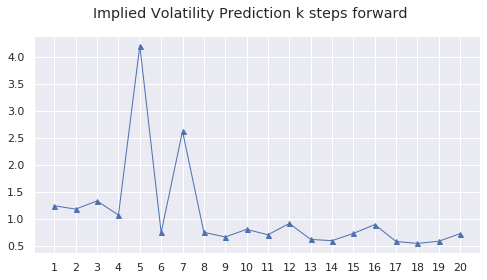

In [5]:
bday_p_year = 252
forward_k = 20

# Make base date
base_date = list(valid_data.keys())[-1]
x = valid_data[base_date][0]["impl_volatility"].values
x = x[np.logical_not(np.isnan(x))]
base_date_vol = np.average(x)


test_days = list(test_data.keys())
test_error_traj_iv = []
for k in range(1, min(forward_k+1, num_test_day+1)):
    k_step_test_error_iv = []
    for idx in range(k-1, num_test_day):
        pred_date = test_days[idx]
        pred_date_p = test_data[pred_date][3]
        pred_date_r = test_data[pred_date][1] 
        pred_date_K = test_data[pred_date][0]["strike_price"].values
        today = [d.date() for d in test_data[pred_date][0]["date"]]
        expireday = [d.date() for d in test_data[pred_date][0]["exdate"]]
        pred_date_T = np.busday_count(today, expireday) / bday_p_year
        pred_date_y = test_data[pred_date][0]["spotclose"].values

        pred_price_iv = BSf(base_date_vol,
                                 p_t=pred_date_p,
                                 r_t=pred_date_r,
                                 K_t=pred_date_K,
                                 T_t=pred_date_T)
        pred_error_iv = np.average(np.abs(pred_price_iv-pred_date_y) / pred_date_y)            
        k_step_test_error_iv.append(pred_error_iv)
        
        base_date = test_days[idx-k+1]
        x = test_data[base_date][0]["impl_volatility"].values
        x = x[np.logical_not(np.isnan(x))]
        base_date_vol = np.average(x)

    test_error_traj_iv.append(np.average(k_step_test_error_iv))
    
%matplotlib inline
sns.set()
fig = plt.figure(figsize=(8,4))
xlabel = list(range(len(test_error_traj_iv)+1))
fig.suptitle("Implied Volatility Prediction k steps forward")
plt.xticks(xlabel)
plt.plot([_+1 for _ in range(forward_k)], test_error_traj_iv, marker ='^', markersize=5, linewidth=1)

fig.show()
errors_to_save.append(test_error_traj_iv)
print("{:.4f}".format(test_error_traj_iv[0]))
print("{:.4f}".format(test_error_traj_iv[4]))
print("{:.4f}".format(test_error_traj_iv[9]))
print("{:.4f}".format(test_error_traj_iv[14]))
print("{:.4f}".format(test_error_traj_iv[19]))

# Test Improved Implied Volatility

0.3804
0.3400
0.3901
0.4422
0.4444


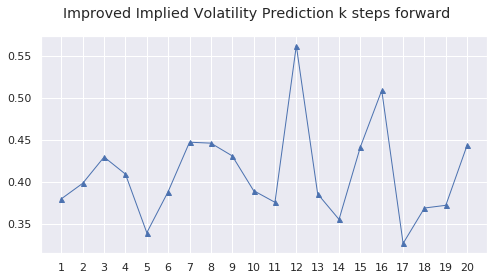

In [6]:
bday_p_year = 252
forward_k = 20

# Make base date
base_date = list(valid_data.keys())[-1]
p_t = valid_data[base_date][3]
r_t = valid_data[base_date][1] 
K_t = valid_data[base_date][0]["strike_price"].values
today = [d.date() for d in valid_data[base_date][0]["date"]]
expireday = [d.date() for d in valid_data[base_date][0]["exdate"]]
T_t = np.busday_count(today, expireday) / bday_p_year
y_t = valid_data[base_date][0]["spotclose"].values
base_date_vols = []
for i in range(topK):
    try:
        temp = optimize.bisect(BSfNT, 0, 2.0, args=(p_t, r_t, K_t[i], T_t[i], y_t[i]))
        base_date_vols.append(temp)
    except ValueError:
        a = test_data[base_date][0]["impl_volatility"].values[i]
        base_date_vols.append(temp)

base_date_vol = np.average(base_date_vols)


test_days = list(test_data.keys())
test_error_traj_imp_iv = []
for k in range(1, min(forward_k+1, num_test_day+1)):
    k_step_test_error_imp_iv = []
    for idx in range(k-1, num_test_day):
        pred_date = test_days[idx]
        pred_date_p = test_data[pred_date][3]
        pred_date_r = test_data[pred_date][1] 
        pred_date_K = test_data[pred_date][0]["strike_price"].values
        today = [d.date() for d in test_data[pred_date][0]["date"]]
        expireday = [d.date() for d in test_data[pred_date][0]["exdate"]]
        pred_date_T = np.busday_count(today, expireday) / bday_p_year
        pred_date_y = test_data[pred_date][0]["spotclose"].values

        pred_price_imp_iv = BSf(base_date_vol,
                                 p_t=pred_date_p,
                                 r_t=pred_date_r,
                                 K_t=pred_date_K,
                                 T_t=pred_date_T)
        pred_error_imp_iv = np.average(np.abs(pred_price_imp_iv-pred_date_y) / pred_date_y)            
        k_step_test_error_imp_iv.append(pred_error_imp_iv)
        
        base_date = test_days[idx-k+1]
        p_t = test_data[base_date][3]
        r_t = test_data[base_date][1] 
        K_t = test_data[base_date][0]["strike_price"].values
        today = [d.date() for d in test_data[base_date][0]["date"]]
        expireday = [d.date() for d in test_data[base_date][0]["exdate"]]
        T_t = np.busday_count(today, expireday) / bday_p_year
        y_t = test_data[base_date][0]["spotclose"].values
        base_date_vols = []
        for i in range(topK):
            try:
                temp = optimize.bisect(BSfNT, 0, 2.0, args=(p_t, r_t, K_t[i], T_t[i], y_t[i]))
                base_date_vols.append(temp)
            except ValueError:
                a = test_data[base_date][0]["impl_volatility"].values[i]
                base_date_vols.append(temp)

        base_date_vol = np.average(base_date_vols)

    test_error_traj_imp_iv.append(np.average(k_step_test_error_imp_iv))
    
%matplotlib inline
sns.set()
fig = plt.figure(figsize=(8,4))
xlabel = list(range(len(test_error_traj_imp_iv)+1))
fig.suptitle("Improved Implied Volatility Prediction k steps forward")
plt.xticks(xlabel)
plt.plot([_+1 for _ in range(forward_k)], test_error_traj_imp_iv, marker ='^', markersize=5, linewidth=1)

fig.show()
errors_to_save.append(test_error_traj_imp_iv)
print("{:.4f}".format(test_error_traj_imp_iv[0]))
print("{:.4f}".format(test_error_traj_imp_iv[4]))
print("{:.4f}".format(test_error_traj_imp_iv[9]))
print("{:.4f}".format(test_error_traj_imp_iv[14]))
print("{:.4f}".format(test_error_traj_imp_iv[19]))

# Test GARCH

0.5768
0.5953
0.6983
0.7049
0.6524


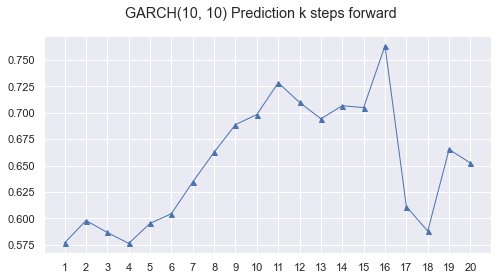

In [7]:
from arch import arch_model
import datetime as dt
import pandas_datareader.data as web
from IPython.utils import io

forward_k = 20

returns = []
index = []
for day in list(train_data.keys()):
    returns.append(train_data[day][2][0])
    index.append(day)
for day in list(valid_data.keys()):
    returns.append(valid_data[day][2][0])
    index.append(day)
last_val_date = list(valid_data.keys())[-1]
last_val_date_idx = len(index)-1

for day in list(test_data.keys()):
    returns.append(test_data[day][2][0])
    index.append(day)
last_test_date = list(test_data.keys())[-1]

start = dt.datetime(2018,1,1)
end = last_test_date
sp500 = web.get_data_yahoo('^GSPC', start=start, end=end)
returns = sp500['Adj Close'].pct_change().dropna()

with io.capture_output() as captured:
    am = arch_model(returns, vol='Garch', p=10, o=0, q=10, dist='Normal')
    res = am.fit(last_obs=last_val_date)
    forecasts = res.forecast(horizon=forward_k, start=last_val_date_idx-1)
    sns.set()
#     forecasts.variance[last_val_date_idx-1:].plot()
prediction = forecasts.variance.iloc[last_val_date_idx-1:]
prediction = prediction.iloc[:-1]
prediction["Date"] = index[last_val_date_idx:-1]
prediction.tail()

bday_p_year = 252

test_error_traj_garch = []

for k in range(1, min(forward_k, num_test_day)+1):
    column_name = "h.{:02d}".format(k)
    column = prediction[[column_name, "Date"]]
    k_step_test_error_garch = []
    for i, base_date in enumerate(column["Date"].values):
        base_date_idx = index.index(base_date)
        try:
            pred_date = index[base_date_idx+k]
            pred_vol = math.sqrt(column[column_name].iloc[i])
        except IndexError:
            break

        pred_date_p = test_data[pred_date][3]
        pred_date_r = test_data[pred_date][1] / bday_p_year
        pred_date_K = test_data[pred_date][0]["strike_price"].values
        today = [d.date() for d in test_data[pred_date][0]["date"]]
        expireday = [d.date() for d in test_data[pred_date][0]["exdate"]]
        pred_date_T = np.busday_count(today, expireday)
        pred_date_y = test_data[pred_date][0]["spotclose"].values

        pred_price_garch = BSf(pred_vol,
                               p_t=pred_date_p, 
                               r_t=pred_date_r, 
                               K_t=pred_date_K, 
                               T_t=pred_date_T)

        pred_error_garch = np.average(np.abs(pred_price_garch-pred_date_y) / pred_date_y)

        k_step_test_error_garch.append(pred_error_garch)
    test_error_traj_garch.append( np.average(k_step_test_error_garch ))

sns.set()
fig = plt.figure(figsize=(8,4))
xlabel = list(range(len(test_error_traj_garch)+1))
fig.suptitle("GARCH(10, 10) Prediction k steps forward")
plt.xticks(xlabel)
plt.plot([_+1 for _ in range(forward_k)], test_error_traj_garch, marker ='^', markersize=5, linewidth=1)
fig.show()


# errors_to_save.append(test_error_traj_garch)
print("{:.4f}".format(test_error_traj_garch[0]))
print("{:.4f}".format(test_error_traj_garch[4]))
print("{:.4f}".format(test_error_traj_garch[9]))
print("{:.4f}".format(test_error_traj_garch[14]))
print("{:.4f}".format(test_error_traj_garch[19]))


# Test Calibrated GARCH

In [8]:
from arch import arch_model
import datetime as dt
import pandas_datareader.data as web
from IPython.utils import io

forward_k = 20

returns = []
index = []
for day in list(train_data.keys()):
    returns.append(train_data[day][2][0])
    index.append(day)
for day in list(valid_data.keys()):
    returns.append(valid_data[day][2][0])
    index.append(day)
last_val_date = list(valid_data.keys())[-1]
last_val_date_idx = len(index)-1

for day in list(test_data.keys()):
    returns.append(test_data[day][2][0])
    index.append(day)
last_test_date = list(test_data.keys())[-1]

start = dt.datetime(2018,1,1)
end = last_test_date
sp500 = web.get_data_yahoo('^GSPC', start=start, end=end)
returns = sp500['Adj Close'].pct_change().dropna()

with io.capture_output() as captured:
    am = arch_model(returns, vol='Garch', p=10, o=0, q=10, dist='Normal')
    res = am.fit(last_obs=last_val_date)
    forecasts = res.forecast(horizon=forward_k, start=last_val_date_idx-1)
    sns.set()
#     forecasts.variance[last_val_date_idx-1:].plot()
prediction = forecasts.variance.iloc[last_val_date_idx-1:]
prediction = prediction.iloc[:-1]
prediction["Date"] = index[last_val_date_idx:-1]
prediction.tail()

bday_p_year = 252

test_error_traj_garch = []

for k in range(1, min(forward_k, num_test_day)+1):
    column_name = "h.{:02d}".format(k)
    column = prediction[[column_name, "Date"]]
    k_step_test_error_garch = []
    for i, base_date in enumerate(column["Date"].values):
        base_date_idx = index.index(base_date)
        try:
            pred_date = index[base_date_idx+k]
            pred_vol = math.sqrt(column[column_name].iloc[i]) +0.001
        except IndexError:
            break

        pred_date_p = test_data[pred_date][3]
        pred_date_r = test_data[pred_date][1] / bday_p_year
        pred_date_K = test_data[pred_date][0]["strike_price"].values
        today = [d.date() for d in test_data[pred_date][0]["date"]]
        expireday = [d.date() for d in test_data[pred_date][0]["exdate"]]
        pred_date_T = np.busday_count(today, expireday)
        pred_date_y = test_data[pred_date][0]["spotclose"].values

        pred_price_garch = BSf(pred_vol,
                               p_t=pred_date_p, 
                               r_t=pred_date_r, 
                               K_t=pred_date_K, 
                               T_t=pred_date_T)

        pred_error_garch = np.average(np.abs(pred_price_garch-pred_date_y) / pred_date_y)

        k_step_test_error_garch.append(pred_error_garch)
    test_error_traj_garch.append( np.average(k_step_test_error_garch ))

sns.set()
fig = plt.figure(figsize=(8,4))
xlabel = list(range(len(test_error_traj_garch)+1))
fig.suptitle("GARCH(10, 10) Prediction k steps forward")
plt.xticks(xlabel)
plt.plot([_+1 for _ in range(forward_k)], test_error_traj_garch, marker ='^', markersize=5, linewidth=1)
fig.show()


# errors_to_save.append(test_error_traj_garch)
print("{:.4f}".format(test_error_traj_garch[0]))
print("{:.4f}".format(test_error_traj_garch[4]))
print("{:.4f}".format(test_error_traj_garch[9]))
print("{:.4f}".format(test_error_traj_garch[14]))
print("{:.4f}".format(test_error_traj_garch[19]))


ModuleNotFoundError: No module named 'pandas_datareader'

# Test HARCH

In [9]:
from arch import arch_model
import datetime as dt
import pandas_datareader.data as web
from IPython.utils import io

forward_k = 20

returns = []
index = []
for day in list(train_data.keys()):
    returns.append(train_data[day][2][0])
    index.append(day)
for day in list(valid_data.keys()):
    returns.append(valid_data[day][2][0])
    index.append(day)
last_val_date = list(valid_data.keys())[-1]
last_val_date_idx = len(index)-1

for day in list(test_data.keys()):
    returns.append(test_data[day][2][0])
    index.append(day)
last_test_date = list(test_data.keys())[-1]

start = dt.datetime(2018,1,1)
end = last_test_date
sp500 = web.get_data_yahoo('^GSPC', start=start, end=end)
returns = sp500['Adj Close'].pct_change().dropna()

with io.capture_output() as captured:
    am = arch_model(returns, vol='Harch', p=18, o=0, q=18, dist='Normal')
    res = am.fit(last_obs=last_val_date)
    forecasts = res.forecast(horizon=forward_k, start=last_val_date_idx-1)
    sns.set()
#     forecasts.variance[last_val_date_idx-1:].plot()
prediction = forecasts.variance.iloc[last_val_date_idx-1:]
prediction = prediction.iloc[:-1]
prediction["Date"] = index[last_val_date_idx:-1]
prediction.tail()

bday_p_year = 252

test_error_traj_Harch = []


for k in range(1, min(forward_k, num_test_day)+1):
    column_name = "h.{:02d}".format(k)
    column = prediction[[column_name, "Date"]]
    k_step_test_error_Harch = []
    for i, base_date in enumerate(column["Date"].values):
        base_date_idx = index.index(base_date)
        try:
            pred_date = index[base_date_idx+k]
            pred_vol = math.sqrt(column[column_name].iloc[i])
        except IndexError:
            break

        pred_date_p = test_data[pred_date][3]
        pred_date_r = test_data[pred_date][1] / bday_p_year
        pred_date_K = test_data[pred_date][0]["strike_price"].values
        today = [d.date() for d in test_data[pred_date][0]["date"]]
        expireday = [d.date() for d in test_data[pred_date][0]["exdate"]]
        pred_date_T = np.busday_count(today, expireday)
        pred_date_y = test_data[pred_date][0]["spotclose"].values

        pred_price_Harch = BSf(pred_vol,
                               p_t=pred_date_p, 
                               r_t=pred_date_r, 
                               K_t=pred_date_K, 
                               T_t=pred_date_T)

        pred_error_Harch = np.average(np.abs(pred_price_Harch-pred_date_y) / pred_date_y)

        k_step_test_error_Harch.append(pred_error_Harch)
    test_error_traj_Harch.append( np.average(k_step_test_error_Harch ))

sns.set()
fig = plt.figure(figsize=(8,4))
xlabel = list(range(len(test_error_traj_Harch)+1))
fig.suptitle("HARCH(18, 18) Prediction k steps forward")
plt.xticks(xlabel)
plt.plot([_+1 for _ in range(forward_k)], test_error_traj_Harch, marker ='^', markersize=5, linewidth=1)
fig.show()

errors_to_save.append(test_error_traj_Harch)
print("{:.4f}".format(test_error_traj_Harch[0]))
print("{:.4f}".format(test_error_traj_Harch[4]))
print("{:.4f}".format(test_error_traj_Harch[9]))
print("{:.4f}".format(test_error_traj_Harch[14]))
print("{:.4f}".format(test_error_traj_Harch[19]))


ModuleNotFoundError: No module named 'pandas_datareader'

# Test LSTM

In [9]:
from torch import nn, optim
import torch

columns = ["date","exdate","strike_price","best_bid","best_offer","volume","impl_volatility"]
start = dt.datetime(2018, 1, 1)
end = dt.datetime(2019, 12, 31)
train_valid_split = 0.936
valid_test_split = 0.94
u_dim = 5
topK = 5
cleaner = dataCleaner_new(columns, u_dim, topK, start, end, train_valid_split, valid_test_split)
return_dict, price_dict = cleaner.make_return_price()
risk_dict = cleaner.make_risk()
train_data, valid_data, test_data = cleaner.make_final_data(price_dict, return_dict, risk_dict)
num_train_day, num_train_obs = cleaner.get_train_num()
num_valid_day, num_valid_obs = cleaner.get_valid_num()
num_test_day, num_test_obs = cleaner.get_test_num()

train_data[np.datetime64('2019-01-02T00:00:00.000000000')]

Attached 351 days of train data
Attached 1755 train option observations
Attached 1 days of validation data
Attached 5 validation option observations
Attached 23 days of test data
Attached 115 test option observations


[              date     exdate  strike_price  best_bid  best_offer  volume  \
 7824298 2019-01-02 2019-06-21        3050.0      3.40         3.7   30005   
 7824308 2019-01-02 2019-06-21        3300.0      0.75         1.0   30005   
 7823256 2019-01-02 2019-01-18        2570.0     14.50        15.3   22363   
 7823260 2019-01-02 2019-01-18        2590.0      9.20         9.8   19735   
 7825956 2019-01-02 2019-01-11        2525.0     23.40        24.0   19555   
 
          impl_volatility  spotclose  
 7824298         0.149985      3.550  
 7824308         0.163895      0.875  
 7823256         0.180783     14.900  
 7823260         0.174487      9.500  
 7825956         0.192232     23.700  ,
 0.0279388,
 array([ 0.04959374,  0.00856268, -0.00124158,  0.00849248,  0.0012685 ]),
 2510.030029]

In [72]:
u_t_regularizer = 1000
r_t_regularizer = 100
p_t_regularizer = 1/1000
K_t_regularizer = 1/1000
T_t_regularizer = 1/10


# Make train and test data
X_train = [] # (num_train_day, topK, input information dim)
Y_train = [] # (num_train_day, topK, 1)
for day in list(train_data.keys()):
    # get observable data
    ## Stock Wise and market wise data
    u_t = train_data[day][2].reshape([1, -1]) * u_t_regularizer
    r_t = (train_data[day][1]).reshape([1, -1]) * r_t_regularizer
    r_t_indata = np.repeat(r_t, topK, axis=0)
    u_quad_t = np.power(u_t, 2)
    u_quad_indata = np.repeat(u_quad_t, topK, axis=0)
    p_t = train_data[day][3].reshape([1,-1]) * p_t_regularizer
    p_t_indata = np.repeat(p_t, topK, axis=0)
    
    ## Option wise data
    K_t = train_data[day][0]["strike_price"].values.reshape([topK, 1]) * K_t_regularizer
    today = [d.date() for d in train_data[day][0]["date"]]
    expireday = [d.date() for d in train_data[day][0]["exdate"]]
    T_t = np.busday_count(today, expireday).reshape([topK, 1]) * T_t_regularizer
    
    #[u_quad_t, p_t, r_t, K_t, T_t]
    x_day_data = np.concatenate((u_quad_indata, p_t_indata, r_t_indata, K_t, T_t), axis = 1).flatten()
    y_day_data = train_data[day][0]["spotclose"].values.reshape([topK, 1]).flatten()
    
    X_train.append(x_day_data)
    Y_train.append(y_day_data)

X_train = np.expand_dims(np.array(X_train), axis=1)
Y_train = np.expand_dims(np.array(Y_train), axis=1)


X_test = [] # (num_valid_day+num_test_day, topK, input information dim)
Y_test = [] # (num_valid_day+num_test_day, topK, 1)
for day in list(valid_data.keys()):
    # get observable data
    ## Stock Wise and market wise data
    u_t = valid_data[day][2].reshape([1, -1]) * u_t_regularizer                            # Regularized
    r_t = (valid_data[day][1]).reshape([1, -1]) * r_t_regularizer                          # Regularized
    r_t_indata = np.repeat(r_t, topK, axis=0)
    u_quad_t = np.power(u_t, 2)
    u_quad_indata = np.repeat(u_quad_t, topK, axis=0)
    p_t = valid_data[day][3].reshape([1,-1]) * p_t_regularizer                             # Regularized
    p_t_indata = np.repeat(p_t, topK, axis=0)
    
    ## Option wise data
    K_t = valid_data[day][0]["strike_price"].values.reshape([topK, 1]) * K_t_regularizer   # Regularized
    today = [d.date() for d in valid_data[day][0]["date"]]
    expireday = [d.date() for d in valid_data[day][0]["exdate"]]
    T_t = np.busday_count(today, expireday).reshape([topK, 1]) * T_t_regularizer           # Regularized
    
    #[u_quad_t, p_t, r_t, K_t, T_t]
    x_day_data = np.concatenate((u_quad_indata, p_t_indata, r_t_indata, K_t, T_t), axis = 1).flatten()
    y_day_data = valid_data[day][0]["spotclose"].values.reshape([topK, 1]).flatten()
    
    X_test.append(x_day_data)
    Y_test.append(y_day_data)

for day in list(test_data.keys()):
    # get observable data
    ## Stock Wise and market wise data
    u_t = test_data[day][2].reshape([1, -1]) * u_t_regularizer
    r_t = (test_data[day][1]).reshape([1, -1]) * r_t_regularizer
    r_t_indata = np.repeat(r_t, topK, axis=0)
    u_quad_t = np.power(u_t, 2)
    u_quad_indata = np.repeat(u_quad_t, topK, axis=0)
    p_t = test_data[day][3].reshape([1,-1]) * p_t_regularizer
    p_t_indata = np.repeat(p_t, topK, axis=0)
    
    ## Option wise data
    K_t = test_data[day][0]["strike_price"].values.reshape([topK, 1]) * K_t_regularizer
    today = [d.date() for d in test_data[day][0]["date"]]
    expireday = [d.date() for d in test_data[day][0]["exdate"]]
    T_t = np.busday_count(today, expireday).reshape([topK, 1]) * T_t_regularizer
    
    #[u_quad_t, p_t, r_t, K_t, T_t]
    x_day_data = np.concatenate((u_quad_indata, p_t_indata, r_t_indata, K_t, T_t), axis = 1).flatten()
    y_day_data = test_data[day][0]["spotclose"].values.reshape([topK, 1]).flatten()
    
    X_test.append(x_day_data)
    Y_test.append(y_day_data)

X_test = np.expand_dims(np.array(X_test), axis=1)
Y_test = np.expand_dims(np.array(Y_test), axis=1)
X_test = np.concatenate((X_train, X_test), axis=0)
Y_test = np.concatenate((Y_train, Y_test), axis=0)


window_size = 25
X_train_windows = [] 
Y_train_windows = []
for i in range(X_train.shape[0]-window_size):
    X_train_windows.append(X_train[i:i+window_size, :, :])
    Y_train_windows.append(Y_train[i:i+window_size, :, :])
X_train_windowed = np.concatenate([p for p in X_train_windows], axis=1)
Y_train_windowed = np.concatenate([p for p in Y_train_windows], axis=1)

seq_length = X_train_windowed.shape[0]
batch_size = X_train_windowed.shape[1]
input_dim = X_train_windowed.shape[2]


print("seq_length = {}".format(seq_length))
print("batch_size = {}".format(batch_size))
print("input_dim = {}".format(input_dim))


Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_train_windowed = torch.tensor(Y_train_windowed, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

print(X_train_windowed.shape)
print(Y_train_windowed.shape)

print("++++++++++++++++++")
print(X_test.shape)
print(Y_test.shape)

seq_length = 25
batch_size = 326
input_dim = 45
(25, 326, 45)
torch.Size([25, 326, 5])
++++++++++++++++++
(375, 1, 45)
torch.Size([375, 1, 5])


In [73]:
# Here we define our model as a class
class Model_LSTM(nn.Module): 

    def __init__(self, input_dim, hidden_dim, output_dim, _num_layers=2):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=_num_layers, dropout = 0.3)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.activate1 = nn.LeakyReLU(inplace = True)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.activate2 = nn.LeakyReLU(inplace = True)
        self.linear3 = nn.Linear(hidden_dim//2, (hidden_dim//2)//2)
        self.activate3 = nn.LeakyReLU(inplace = True)
        self.linear4 = nn.Linear((hidden_dim//2)//2, output_dim)
        

    def forward(self, Input, h_0, c_0):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        
        Input = torch.Tensor(Input)
        lstm_out, (_, _) = self.lstm(Input, (h_0, c_0))
        linear1_out = self.linear1(lstm_out)
        linear2_out = self.linear2(self.activate1(linear1_out))
        linear3_out = self.linear3(self.activate2(linear2_out))
        linear4_out = self.linear4(self.activate3(linear3_out))
        return linear4_out

In [78]:
def err_fn(truth, pred):
    return torch.abs(truth - pred) / truth

def MAPELoss(output, target):
    return torch.mean(torch.abs((target - output) / target))    


num_lstm = 2
hidden_dimension = 64

lstm_model = Model_LSTM(input_dim, hidden_dim=hidden_dimension, output_dim=topK, _num_layers=num_lstm)
loss_fn = MAPELoss
optimiser = torch.optim.Adam(lstm_model.parameters(), lr=0.02, weight_decay=0.8)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma = 0.99)

num_epochs = 200
h_0 = torch.randn((num_lstm, 1, hidden_dimension))
c_0 = torch.randn((num_lstm, 1, hidden_dimension))

h_p = torch.cat([h_0 for _ in range(batch_size)], axis=1)
c_p = torch.cat([c_0 for _ in range(batch_size)], axis=1)

for t in range(num_epochs):
    # Forward pass
    Y_pred = lstm_model.forward(X_train_windowed, h_p, c_p)
    train_loss = loss_fn(Y_pred, Y_train_windowed)
    optimiser.zero_grad()
    train_loss.backward()
    optimiser.step()
    scheduler.step()


    if t % 5 == 0:
        # testing
        prediction = lstm_model.forward(X_test, h_0, c_0)
        Y_train_pred = prediction[:num_train_day]
        Y_train_truth = Y_test[:num_train_day]
        train_loss = loss_fn(Y_train_pred, Y_train_truth)

        Y_test_pred = prediction[num_train_day:]
        Y_test_truth = Y_test[num_train_day:]
        test_loss = loss_fn(Y_test_pred, Y_test_truth)

        print("Epoch {:3} train error: {:.4f} | test error: {:.4f}".format(t, train_loss.item(), test_loss.item()))

Epoch   0 train error: 0.9860 | test error: 1.0480
Epoch   5 train error: 0.9834 | test error: 0.9628
Epoch  10 train error: 0.9817 | test error: 0.9309
Epoch  15 train error: 0.9839 | test error: 0.9281
Epoch  20 train error: 0.9832 | test error: 0.9262
Epoch  25 train error: 0.9808 | test error: 0.9216
Epoch  30 train error: 0.9792 | test error: 0.9261
Epoch  35 train error: 0.9789 | test error: 0.9352
Epoch  40 train error: 0.9789 | test error: 0.9400
Epoch  45 train error: 0.9797 | test error: 0.9421
Epoch  50 train error: 0.9798 | test error: 0.9391
Epoch  55 train error: 0.9803 | test error: 0.9367
Epoch  60 train error: 0.9805 | test error: 0.9344
Epoch  65 train error: 0.9805 | test error: 0.9332
Epoch  70 train error: 0.9803 | test error: 0.9329
Epoch  75 train error: 0.9805 | test error: 0.9348
Epoch  80 train error: 0.9801 | test error: 0.9343
Epoch  85 train error: 0.9802 | test error: 0.9355
Epoch  90 train error: 0.9802 | test error: 0.9356
Epoch  95 train error: 0.9802 |

In [71]:
Y_test_pred = prediction[num_train_day:]
Y_test_truth = Y_test[num_train_day:]
test_loss = loss_fn(Y_test_pred, Y_test_truth)
test_errors = torch.mean(err_fn(Y_test_truth, Y_test_pred), dim=2)
print(test_errors[0])
print(test_errors[4])
print(test_errors[9])
print(test_errors[14])
print(test_errors[19])

tensor([0.8055], grad_fn=<SelectBackward>)
tensor([0.9837], grad_fn=<SelectBackward>)
tensor([0.8373], grad_fn=<SelectBackward>)
tensor([0.9933], grad_fn=<SelectBackward>)
tensor([0.9898], grad_fn=<SelectBackward>)


# RNN

In [92]:
# Here we define our model as a class
class Model_RNN(nn.Module): 

    def __init__(self, input_dim, hidden_dim, output_dim, _num_layers=2):
        super().__init__()
        
        self.RNN = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=_num_layers, dropout = 0.3)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.activate1 = nn.LeakyReLU(inplace = True)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.activate2 = nn.LeakyReLU(inplace = True)
        self.linear3 = nn.Linear(hidden_dim//2, (hidden_dim//2)//2)
        self.activate3 = nn.LeakyReLU(inplace = True)
        self.linear4 = nn.Linear((hidden_dim//2)//2, output_dim)
        

    def forward(self, Input, h_0):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        
        Input = torch.Tensor(Input)
        RNN_out, (_, _) = self.RNN(Input, h_0 )
        linear1_out = self.linear1(RNN_out)
        linear2_out = self.linear2(self.activate1(linear1_out))
        linear3_out = self.linear3(self.activate2(linear2_out))
        linear4_out = self.linear4(self.activate3(linear3_out))
        return linear4_out

In [93]:
def err_fn(truth, pred):
    return torch.abs(truth - pred) / truth

def MAPELoss(output, target):
    return torch.mean(torch.abs((target - output) / target))    


num_RNN = 2
hidden_dimension = 128

RNN_model = Model_RNN(input_dim, hidden_dim=hidden_dimension, output_dim=topK, _num_layers=num_RNN)
loss_fn = MAPELoss
optimiser = torch.optim.Adam(RNN_model.parameters(), lr=0.02, weight_decay=0.8)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma = 0.99)

num_epochs = 200
h_0 = torch.randn((num_RNN, 1, hidden_dimension))
h_p = torch.cat([h_0 for _ in range(batch_size)], axis=1)

for t in range(num_epochs):
    # Forward pass
    Y_pred = RNN_model.forward(X_train_windowed, h_p)
    train_loss = loss_fn(Y_pred, Y_train_windowed)
    optimiser.zero_grad()
    train_loss.backward()
    optimiser.step()
    scheduler.step()


    if t % 5 == 0:
        # testing
        prediction = RNN_model.forward(X_test, h_0)
        Y_train_pred = prediction[:num_train_day]
        Y_train_truth = Y_test[:num_train_day]
        train_loss = loss_fn(Y_train_pred, Y_train_truth)

        Y_test_pred = prediction[num_train_day:]
        Y_test_truth = Y_test[num_train_day:]
        test_loss = loss_fn(Y_test_pred, Y_test_truth)

        print("Epoch {:3} train error: {:.4f} | test error: {:.4f}".format(t, train_loss.item(), test_loss.item()))

Epoch   0 train error: 0.9939 | test error: 1.0298
Epoch   5 train error: 0.9883 | test error: 0.9765
Epoch  10 train error: 0.9793 | test error: 0.9340
Epoch  15 train error: 0.9763 | test error: 0.9309
Epoch  20 train error: 0.9772 | test error: 0.9324
Epoch  25 train error: 0.9798 | test error: 0.9341
Epoch  30 train error: 0.9815 | test error: 0.9402
Epoch  35 train error: 0.9819 | test error: 0.9400
Epoch  40 train error: 0.9812 | test error: 0.9390
Epoch  45 train error: 0.9809 | test error: 0.9366
Epoch  50 train error: 0.9801 | test error: 0.9347
Epoch  55 train error: 0.9798 | test error: 0.9335
Epoch  60 train error: 0.9803 | test error: 0.9356
Epoch  65 train error: 0.9806 | test error: 0.9361
Epoch  70 train error: 0.9804 | test error: 0.9359
Epoch  75 train error: 0.9804 | test error: 0.9354
Epoch  80 train error: 0.9802 | test error: 0.9350
Epoch  85 train error: 0.9801 | test error: 0.9346
Epoch  90 train error: 0.9803 | test error: 0.9353
Epoch  95 train error: 0.9803 |

KeyboardInterrupt: 